In [1]:
#5yrs depth change maps 
#make similar plots for all depth change data - measurements & simulation
from netCDF4 import Dataset
import numpy as  np
import matplotlib.pyplot as plt
import geopandas as gpd

import glob
import os.path
import sys
import h5py

sys.path.insert(0, '/home/g/g260204/tools/python_skripts/SchismUtils/')
from schism_utils import read_data, sort_files

from matplotlib import rcParams
rcParams['figure.dpi'] = 300

In [2]:
vmin = -3
vmax = 3
seagrass = False
sim = 'srm024'
outname = sim + '_2010'
plot_path = '/work/gg0877/g260204/sim_data/SR5yr/plots/plots/' + outname + '/'


#area inside basin
hdf5pat = '/work/gg0877/g260204/data/pickle_files/mask_basin.hdf5'
f = h5py.File(hdf5pat,'r')
nin = f['nin'][:]

ncdata = Dataset('/work/gg0877/g260204/sim_data/SR5yr/srm024_2010/outputs/schout_1.nc',mode='r')

#calculate area and ini depth of element
x = ncdata.variables['SCHISM_hgrid_node_x'][:]
y = ncdata.variables['SCHISM_hgrid_node_y'][:]
tri = ncdata.variables['SCHISM_hgrid_face_nodes'][:, :3]-1
depth = ncdata.variables['depth'][:]

#ii = np.where(np.sum(nin[tri],1)==3)
ii = np.where(nin==1)
f.close()


In [11]:
#input data: measurements
#get shape:
froot = 'syltromo100m_'
Path = '/home/g/g260204/01_preprog/1_grids/syltromo/2010-2016/'
f1 = Path+froot+'2010'+'.gr3'
head = np.loadtxt(f1,skiprows=1,max_rows=1,dtype='int')
obs_all = np.zeros(head[1])
nobs = 0
    
for i in range(2010,2014):
    froot = 'syltromo100m_'
    Path = '/home/g/g260204/01_preprog/1_grids/syltromo/2010-2016/'
    f1 = Path+froot+str(i)+'.gr3'
    head = np.loadtxt(f1,skiprows=1,max_rows=1,dtype='int')
    z1= np.loadtxt(f1, usecols=(3), skiprows=2, max_rows=head[1],dtype='float') 

    f2 = Path+froot+str(i+1)+'.gr3'
    z2 = np.loadtxt(f2, usecols=3, skiprows=2, max_rows=head[1],dtype='float')
    obs_all += -(z2-z1)
    obs_all[ii]= 0
    #obs_all[np.abs(obs_all)<np.std(obs_all)]= 0
    nobs += 1

obs_all = obs_all/nobs
depth = z1
#read x,y
x = np.loadtxt(f1, usecols=(1), skiprows=2, max_rows=head[1],dtype='float')
y = np.loadtxt(f1, usecols=(2), skiprows=2, max_rows=head[1],dtype='float')

#read tri
tri = np.loadtxt(f1, usecols=(2,3,4), skiprows=2+head[1],max_rows=head[0],dtype='int')-1

In [12]:
#standart deviation of measurment data
np.std(obs_all)

0.11544552584393235

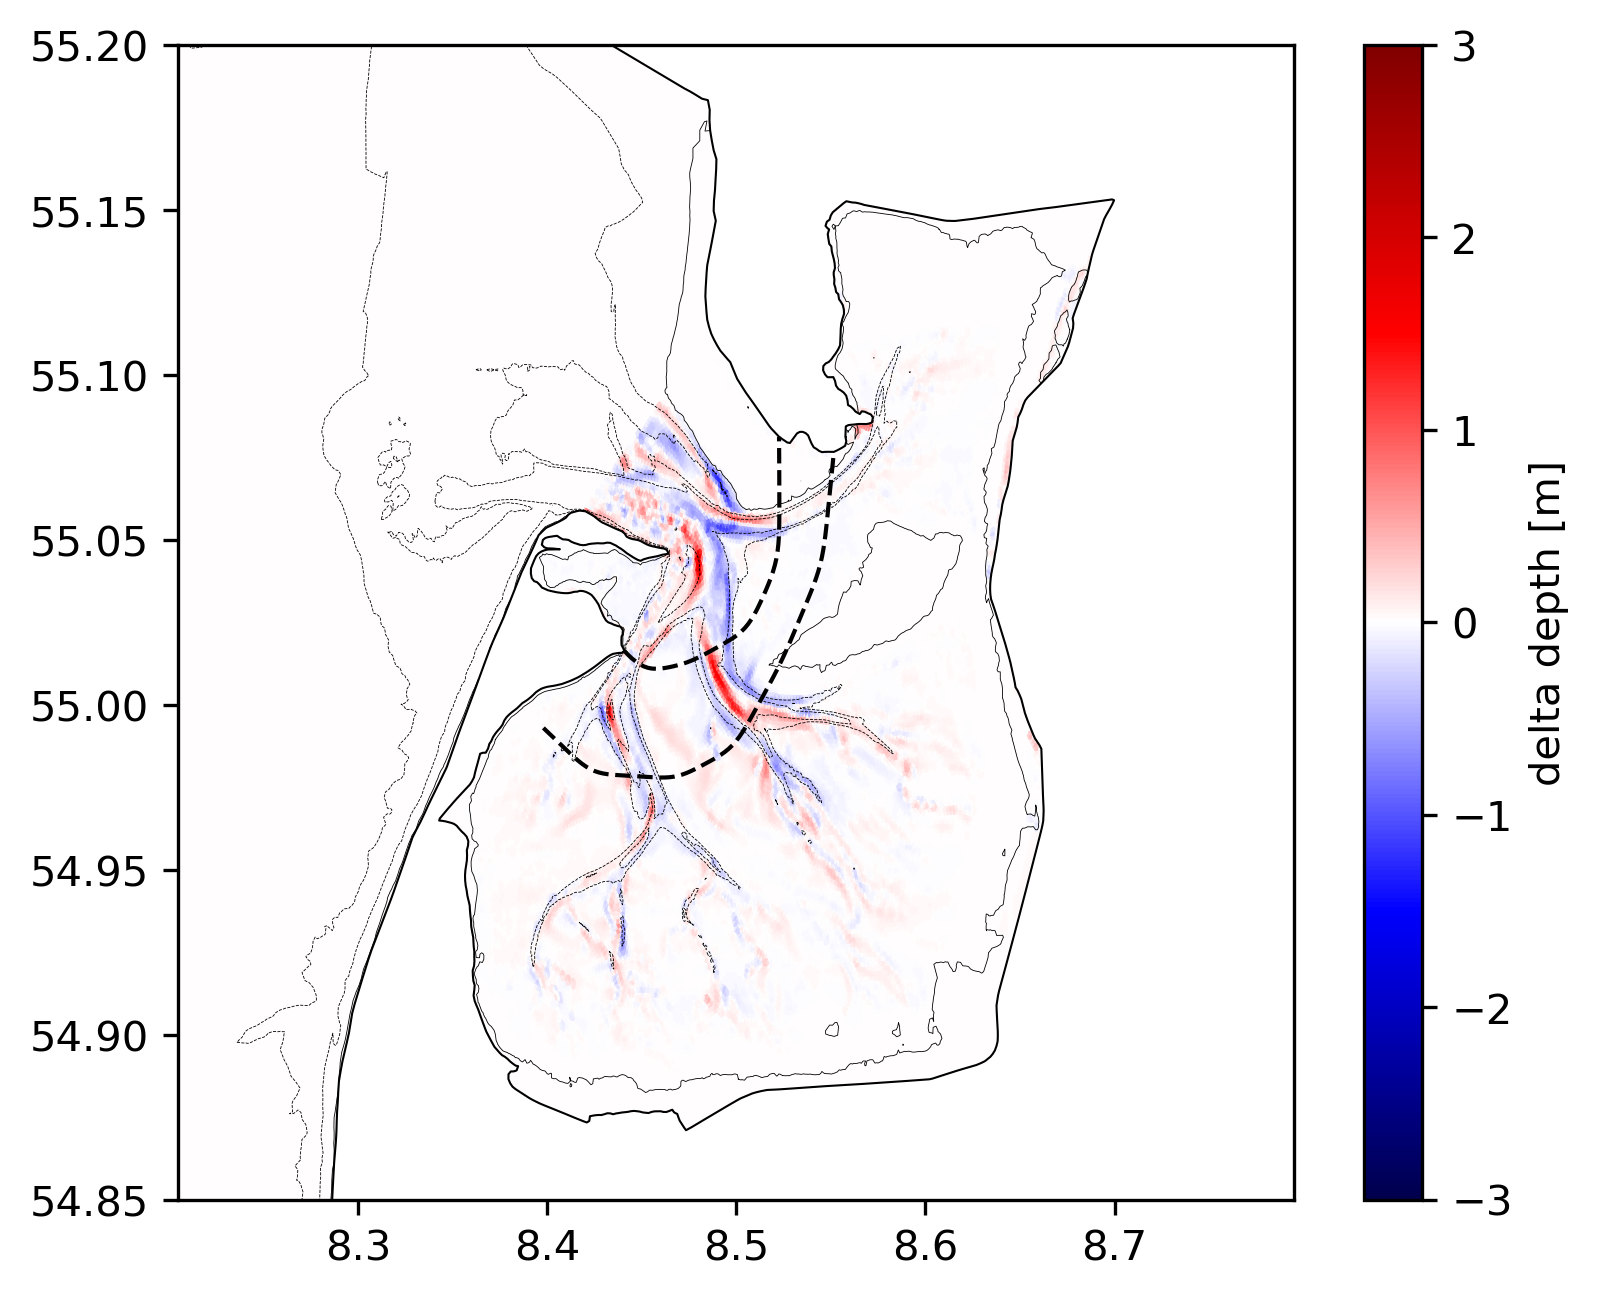

In [13]:
#plot obs 
fig = plt.figure(figsize=(6,5))
plt.tripcolor(x, y, tri, obs_all, cmap='seismic',edgecolors='face',vmin=vmin, vmax=vmax)#,facecolors='none')

plt.xlabel('')
plt.ylabel('')
plt.axis('equal')
cbar = plt.colorbar()
cbar.set_label('delta depth [m]')
shp_pat = '/work/gg0877/g260204/sim_data/SyltRomo/01_preprog/100m/syltromo_silhouette.shp'
shape = gpd.read_file(shp_pat)
shape.boundary.plot(ax=plt.gca(),color='k',linewidth=0.5)
plt.tricontour(x,y,tri,-depth,[-10,-5,0],colors='k',linewidths=0.2)
plt.xlim(8.3,8.7)
plt.ylim(54.85,55.2)
#plt.title('depth change ' + savename)
#transect lines along channel
transfiles = '/work/gg0877/g260204/data/transects/'
hdp = gpd.read_file(transfiles + 'cross_flats2.shp')
lly = gpd.read_file(transfiles + 'cross_channels.shp')
rdp = gpd.read_file(transfiles + 'cross_flats.shp')
#hdp.plot(ax=plt.gca(),color='k',linestyle='dashed',linewidth=1)
lly.plot(ax=plt.gca(),color='k',linestyle='dashed',linewidth=1)
rdp.plot(ax=plt.gca(),color='k',linestyle='dashed',linewidth=1)

plt.savefig(plot_path + 'depth_change_obs_mean_cross.png')

In [6]:
#inputdata: simulation
#input

simpat = '/work/gg0877/g260204/sim_data/SR5yr/'
#get shape
ncpat = simpat + sim +'_2011/outputs/schout_365.nc'
depth_change = -np.squeeze(read_data('SED_depth_change',[ncpat],ntime=[23]))
all_sim = np.zeros(np.shape(depth_change))

vmin = -3
vmax = 3
seagrass = False
nsim = 0
#find files
for i in range(2010,2016):
    simname = sim + '_'+ str(i)
    ncpat = simpat + simname +'/outputs/schout_358.nc'

    #read data 1
    ncdata = Dataset(ncpat, mode='r')

    #time dependent
    all_sim += -np.squeeze(read_data('SED_depth_change',[ncpat],ntime=[-1]))
    nsim +=1
    all_sim[ii]=0
    #all_sim[np.abs(obs_all)<np.std(obs_all)]= 0
    
#time independent
x       = ncdata.variables['SCHISM_hgrid_node_x'][:]
y       = ncdata.variables['SCHISM_hgrid_node_y'][:]
tri     = ncdata.variables['SCHISM_hgrid_face_nodes'][:,:3]-1
depth   = ncdata.variables['depth'][:]
all_sim = all_sim/nsim
savename = simname

#difference:
diff = obs_all-all_sim

Loading files (srm024_2015, SED_depth_change): 100%|██████████| 1/1 [00:00<00:00, 28.71it/s]


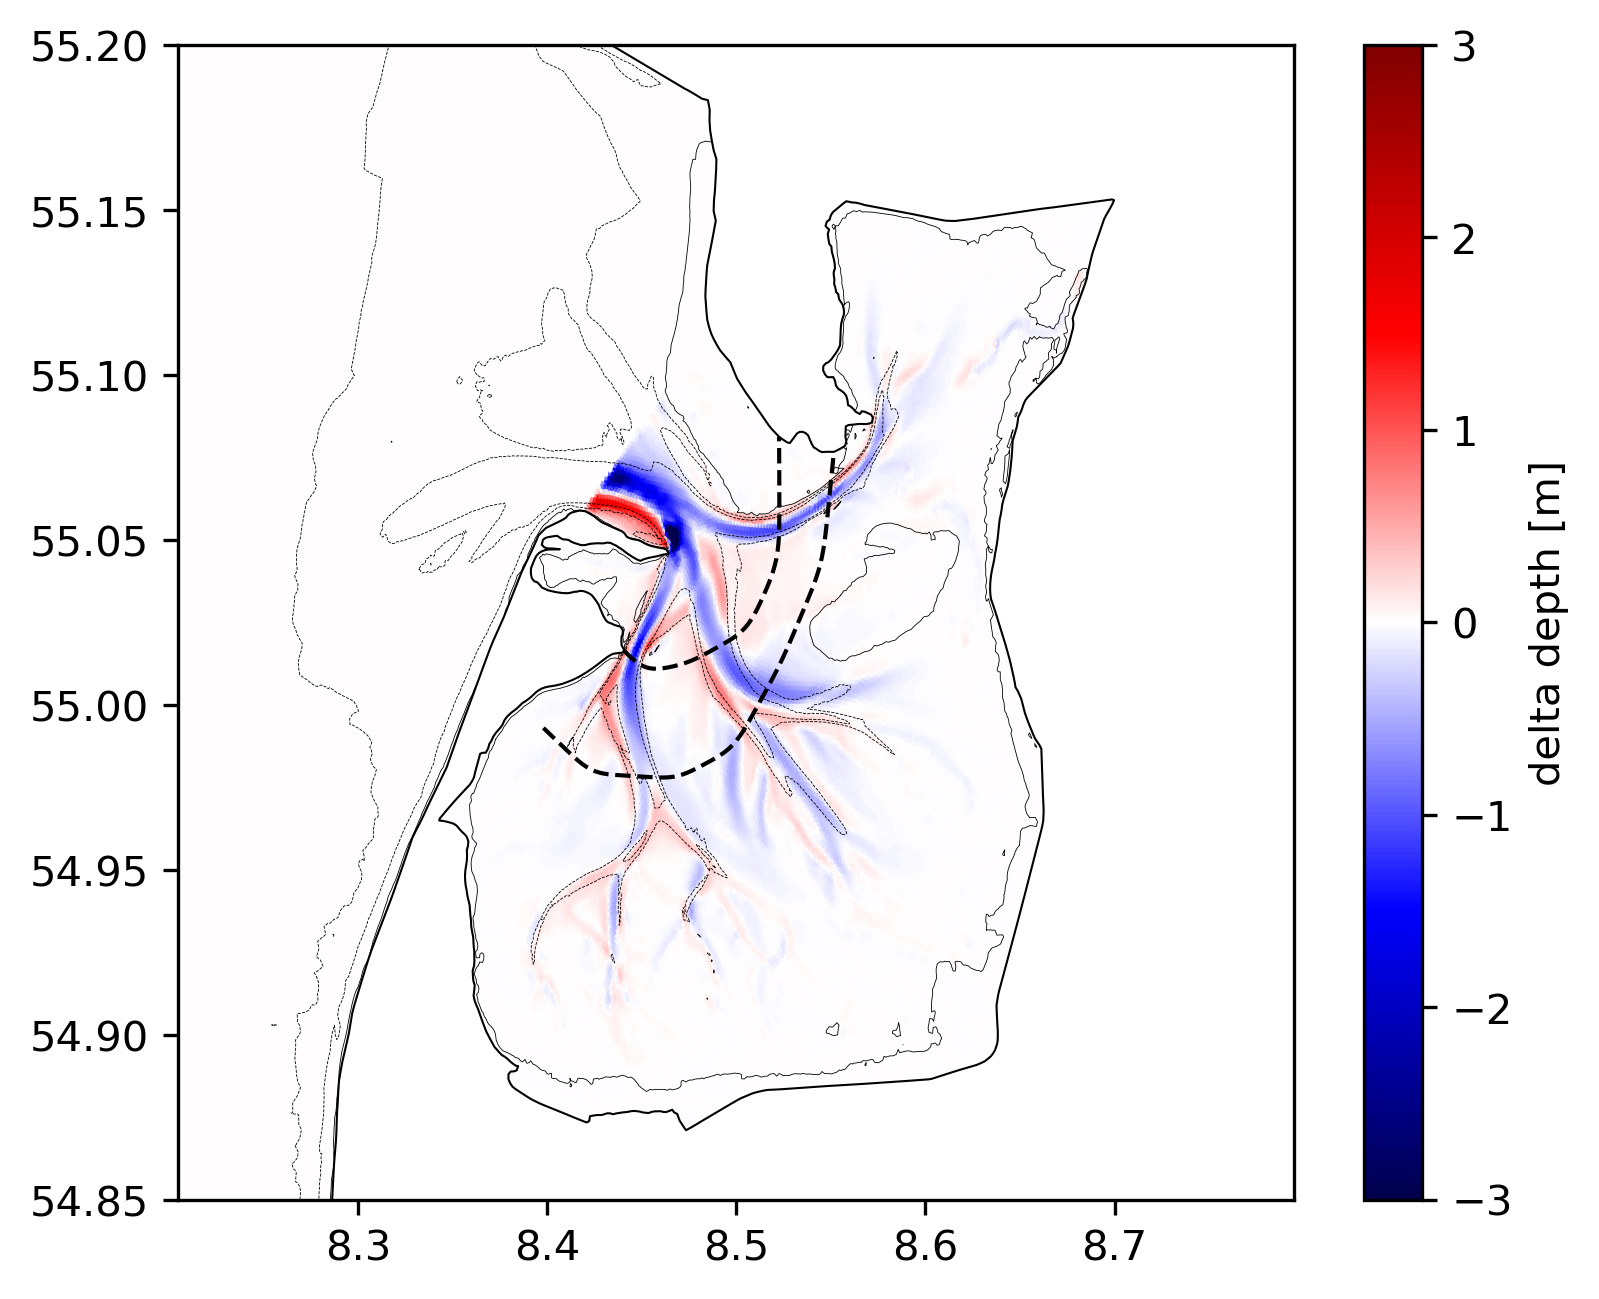

In [7]:
#plot sim
fig = plt.figure(figsize=(6,5))
plt.tripcolor(x, y, tri, all_sim, cmap='seismic',edgecolors='face',vmin=vmin, vmax=vmax)#,facecolors='none')

plt.xlabel('')
plt.ylabel('')
plt.axis('equal')
cbar = plt.colorbar()
cbar.set_label('delta depth [m]')
shp_pat = '/work/gg0877/g260204/sim_data/SyltRomo/01_preprog/100m/syltromo_silhouette.shp'
shape = gpd.read_file(shp_pat)
shape.boundary.plot(ax=plt.gca(),color='k',linewidth=0.5)
plt.tricontour(x,y,tri,-depth,[-10,-5,0],colors='k',linewidths=0.2)
plt.xlim(8.3,8.7)
plt.ylim(54.85,55.2)
#plt.title('depth change ' + savename)
#transect lines along channel
transfiles = '/work/gg0877/g260204/data/transects/'
hdp = gpd.read_file(transfiles + 'cross_flats2.shp')
lly = gpd.read_file(transfiles + 'cross_channels.shp')
rdp = gpd.read_file(transfiles + 'cross_flats.shp')
#hdp.plot(ax=plt.gca(),color='k',linestyle='dashed',linewidth=1)
lly.plot(ax=plt.gca(),color='k',linestyle='dashed',linewidth=1)
rdp.plot(ax=plt.gca(),color='k',linestyle='dashed',linewidth=1)

plt.savefig(plot_path +simname+ '_depth_change_sim_mean_cross.png')

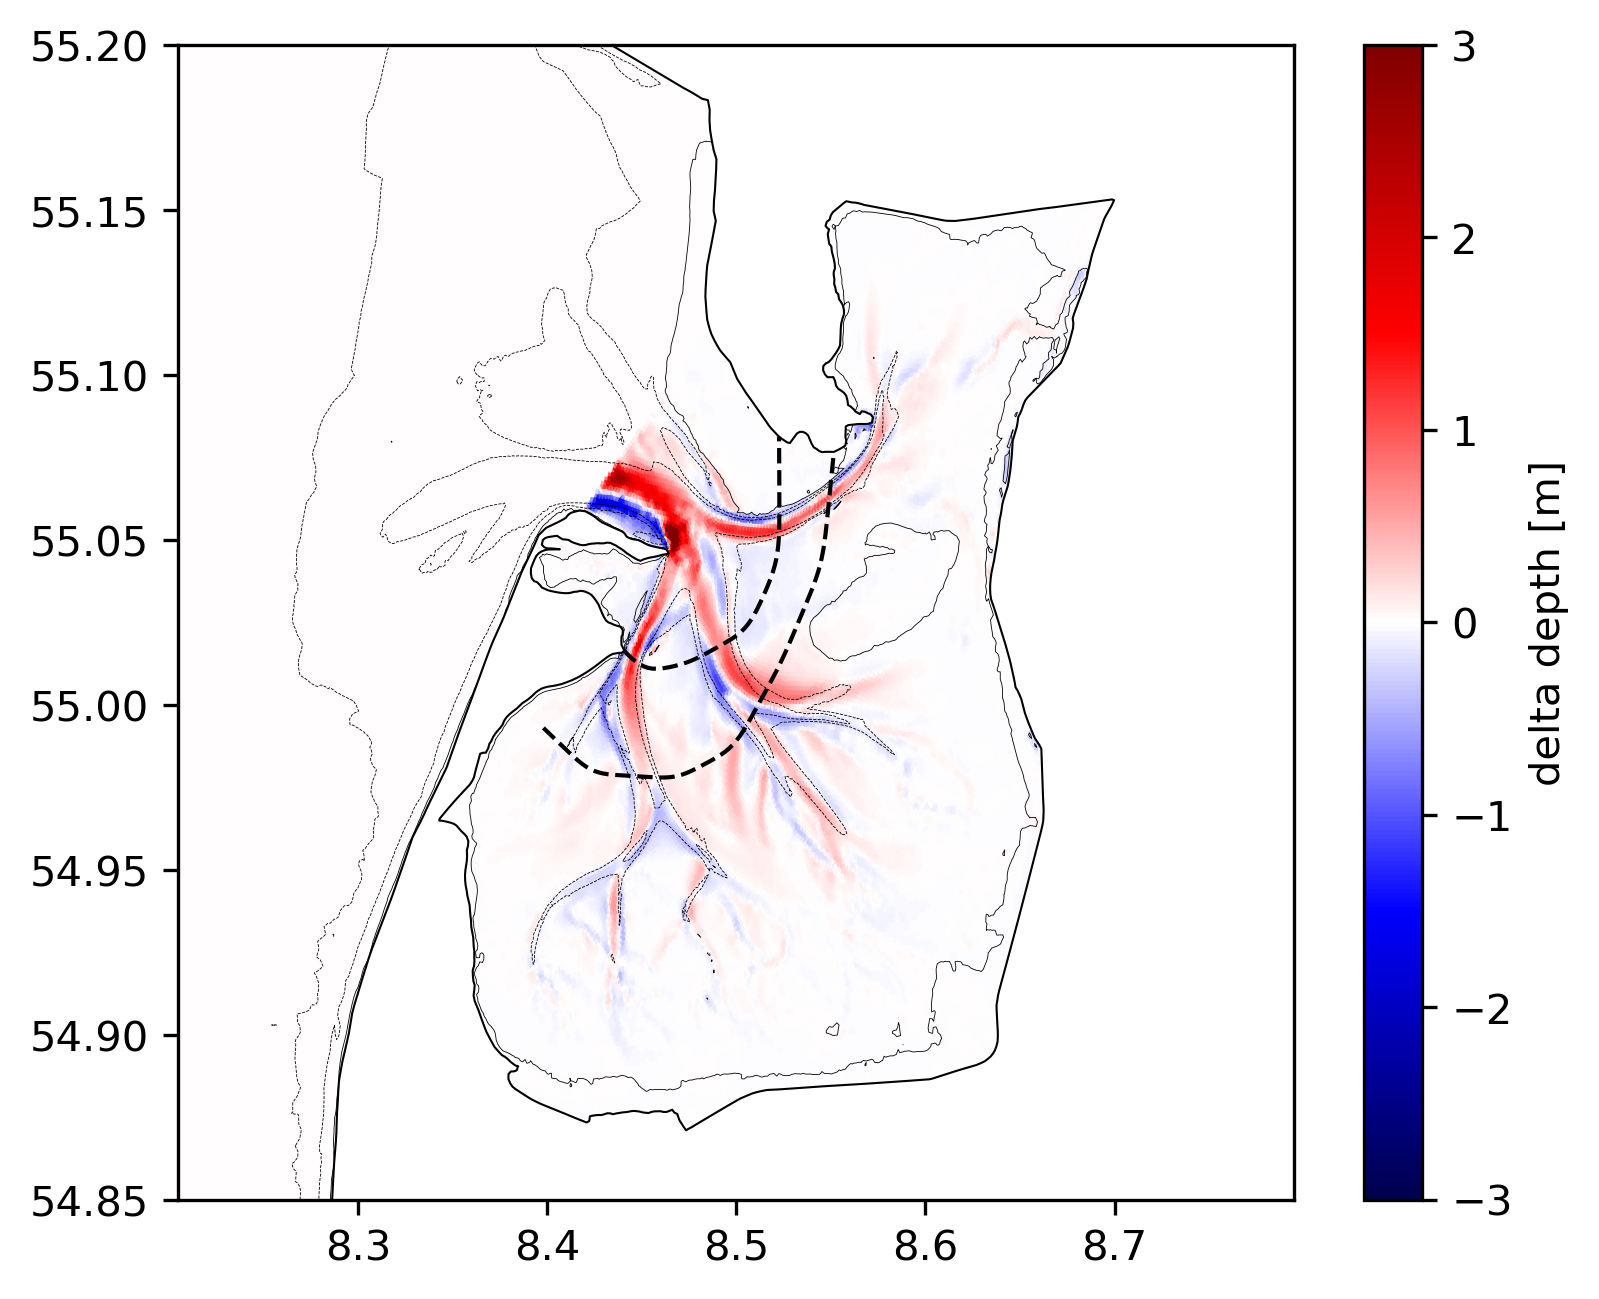

In [8]:


#plot diff
fig = plt.figure(figsize=(6,5))
plt.tripcolor(x, y, tri, diff, cmap='seismic',edgecolors='face',vmin=vmin, vmax=vmax)#,facecolors='none')

plt.xlabel('')
plt.ylabel('')
plt.axis('equal')
cbar = plt.colorbar()
cbar.set_label('delta depth [m]')
shp_pat = '/work/gg0877/g260204/sim_data/SyltRomo/01_preprog/100m/syltromo_silhouette.shp'
shape = gpd.read_file(shp_pat)
shape.boundary.plot(ax=plt.gca(),color='k',linewidth=0.5)
plt.tricontour(x,y,tri,-depth,[-10,-5,0],colors='k',linewidths=0.2)
plt.xlim(8.3,8.7)
plt.ylim(54.85,55.2)
#plt.title('depth change ' + savename)
#transect lines along channel
transfiles = '/work/gg0877/g260204/data/transects/'
hdp = gpd.read_file(transfiles + 'cross_flats2.shp')
lly = gpd.read_file(transfiles + 'cross_channels.shp')
rdp = gpd.read_file(transfiles + 'cross_flats.shp')
#hdp.plot(ax=plt.gca(),color='k',linestyle='dashed',linewidth=1)
lly.plot(ax=plt.gca(),color='k',linestyle='dashed',linewidth=1)
rdp.plot(ax=plt.gca(),color='k',linestyle='dashed',linewidth=1)

plt.savefig(plot_path +simname+ '_depth_change_diff_mean_cross.png')

In [9]:
rmse = np.sqrt(np.mean(diff**2))
print(rmse)

0.19413591416185713


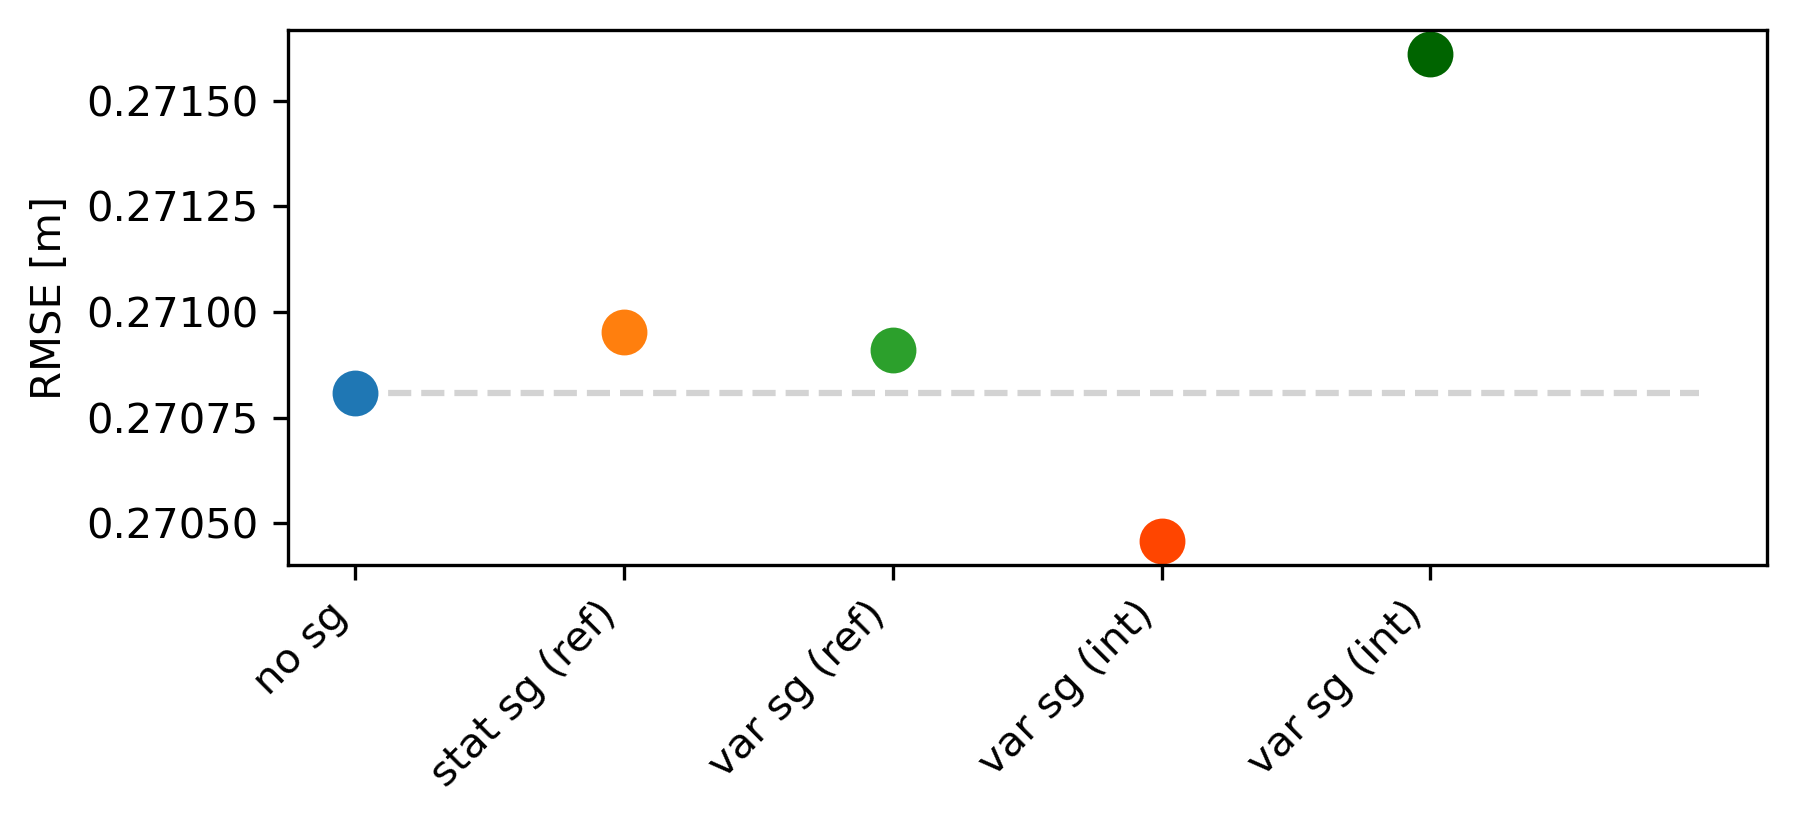

In [10]:
run_labels=['no sg','stat sg (ref)','var sg (ref)','var sg (int)','var sg (int)']
colors = ['tab:blue','tab:orange','tab:green','orangered','darkgreen']
runs=['srm020','srm026','srm024','srm035','srm036']
#rmss = {'srm020' :0.1894680841616259, 'srm026' : 0.18932623113595007,'srm024' : 0.18947299435101067,'srm035' :0.18772458985249132, 'srm036' :0.18830301723467494} #all years
rmss = {'srm020' :0.27080975954863834, 'srm026' :0.2709524372927192 ,'srm024' : 0.27090963822152647,'srm035' :0.27045867564098974, 'srm036' :0.27161005153496326} #only 2010
#rmss = {'srm020' :0.19681523449041297, 'srm026' :0.19660739946433914 ,'srm024' :0.19692919123747446 ,'srm035' :0.19506704602797204, 'srm036' :0.19564695362073006} #without 2010

#plt.plot(rmss,'.')
fig = plt.figure(figsize=(6,3))
xl = 1
plt.plot([1,len(runs)+1],[rmss['srm020'],rmss['srm020']],'--',color='lightgrey')
for r,c,l in zip(runs,colors,run_labels):
    plt.plot(xl,rmss[r],'.',color=c , markersize=20)
    xl += 1
    
plt.xticks(ticks=range(1,len(runs)+1), labels=run_labels, ha = 'right')
#plt.ylim([0.2,0.208])
plt.ylabel('RMSE [m]')
# Optionally, rotate the x-axis labels if they are too long
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('/work/gg0877/g260204/sim_data/SR5yr/plots/plots/srm203536/rmse_depth_change_2010.png')